In [39]:
import emcee
import corner
import arviz as az
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.special import erf

#%matplotlib inline
#np.random.seed(1234)

az.style.use("arviz-darkgrid")

# Nice plotting options.
params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

# Gaussian-Gaussian example

We consider a scenario where noise ($ n $) and signal ($\theta$) both are normally distributed, i.e. $n  \sim \mathcal{N}(0, \sigma^2)$ and $\theta \sim \mathcal{N}(\mu, \Sigma^2)$.

Then, observations

$$d = \theta + n$$

###  Compute the likelihood of hyper-parameters ($\mu, \Sigma$) in the presence of selection effects:

$$p(d|\vec{\lambda} \equiv \{\mu, \Sigma, \sigma \}) = \frac{1}{\alpha(\vec{\lambda})} \int d\theta p(d|\theta) p(\theta|\vec{\lambda})$$

Analytical calculation will render:

$$p(d|\vec{\lambda}) = \frac{1}{\alpha(\vec{\lambda})} \frac{1}{\sqrt{2 \pi (\sigma^2 + \Sigma^2)}} \exp \left[ -\frac{(d-\mu)^2}{2(\sigma^2 + \Sigma^2)}\right] \equiv \frac{1}{\alpha(\vec{\lambda})} \mathcal{N}(\mu, \sigma^2 + \Sigma^2)$$

For $N_{\mathrm{det}}$ observations, i.e. $D \equiv \{ d_1, d_2, ..., d_{N_{\mathrm{det}}} \}$, under the assumption of all the observations being independent of each other, the hyper-likelihood

$$p(D|\vec{\lambda} \equiv \{\mu, \Sigma^2 \}) = \prod_{i=1}^{N_{\mathrm{det}}} \frac{\int d\theta_i p(d_i|\theta_i) p(\theta_i|\vec{\lambda})}{\alpha(\vec{\lambda})}$$

Where $\alpha(\vec{\lambda})$ is the selection effect here.


### (e) plotting the observations

In [44]:
# Number of observations
N_samples = 10**5

# True values of population hyper-parameters
mu_true = 0.5 
Sigma_true =1 

# Spread of noise distribution
sigma = 0.1

In [45]:
# number of samples
N_samples = 10**5

# generating samples
theta = np.random.normal(mu_true, Sigma_true, N_samples)

# generating noise
noise = np.random.normal(0.0, sigma, N_samples)

# Observations
data = theta + noise

#### Applying the detection threshold to the data

In [46]:
d_th = 0.0

selected_indices = data > d_th

data_selection_effects = data[selected_indices]

Text(0.5, 0, '$d$')

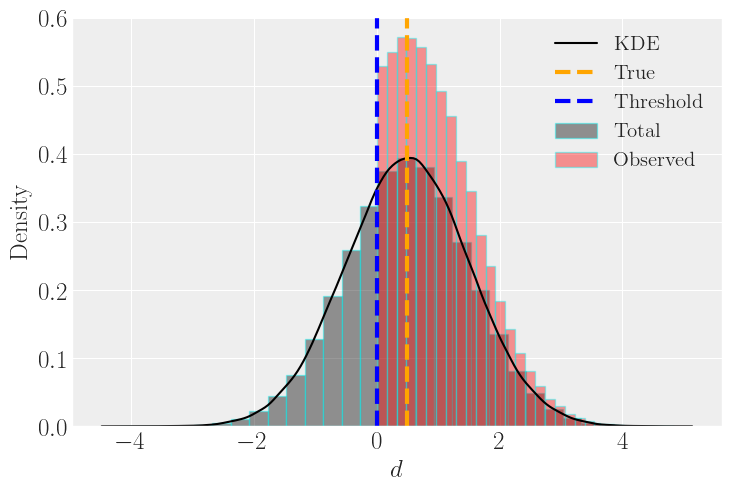

In [47]:
#plt.figure(figsize=(10, 7))
plt.hist(data, density=True,label='Total',bins=30,histtype = 'bar',
                               color ='black', alpha=0.4, edgecolor='cyan')
plt.hist(data_selection_effects, density=True,label='Observed',bins=30,histtype = 'bar',
                               color ='r', alpha=0.4, edgecolor='cyan')
sns.kdeplot(np.array(data), label='KDE',c='black')
plt.axvline(x=mu_true, label='True', c='orange',ls='--',lw=3)
plt.axvline(x=d_th, label='Threshold', c='b',ls='--',lw=3)
plt.ylabel('Density')
plt.legend(loc='best')
plt.xlabel('$d$')
#plt.grid()

### (f) Compute the selection effects:


$$\alpha(\vec{\lambda}) = \int_{d_{\mathrm{th}}}^\infty d d \int d\theta p(d|\theta) p(\theta|\vec{\lambda}) = \int_{d_{\mathrm{th}}}^\infty d d \mathcal{N}(\mu, \sigma^2 + \Sigma^2) $$

$$\alpha(\vec{\lambda}) = \frac{1}{2} \mathrm{erfc} \left[ \frac{d_{\mathrm{th}} - \mu}{\sqrt{2 (\sigma^2 + \Sigma^2)}} \right] $$


In [48]:
def selection_effects(d_th, mu, Sigma_sq, sigma_sq):
    
    alpha_lambda = 0.5 * erfc((d_th - mu)/np.sqrt(2 * (Sigma_sq + sigma_sq)))
    
    return alpha_lambda

### plotting selection effects:

In [90]:
Sigma_sq_vec = np.linspace(Sigma_sq_min_prior, Sigma_sq_max_prior, 100)
sigma_sq_vec = np.ones(100) * sigma
mu_vec = np.linspace(mean_min_prior, mean_max_prior, 100)
alpha_lambda_mu = selection_effects(0, mu_vec, Sigma_true**2, sigma**2)
alpha_lambda_Sigma_sq = selection_effects(0, mu_true, Sigma_sq_vec**2, sigma_sq_vec**2)

Text(0.5, 0, '$\\Sigma^2$')

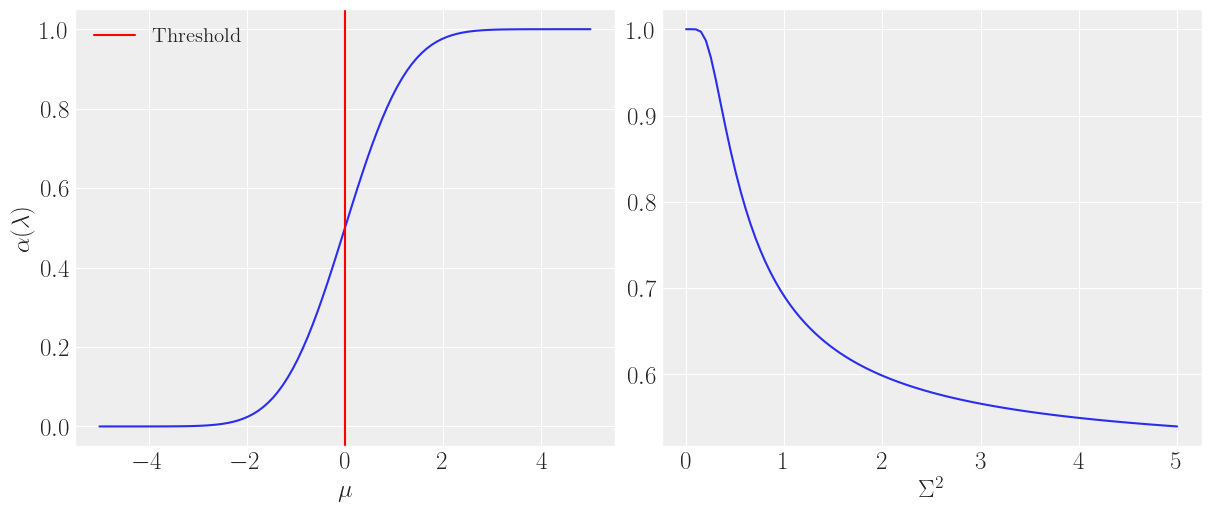

In [92]:
figure = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.subplot(121)
plt.plot(mu_vec, alpha_lambda_mu)
plt.axvline(x=d_th, c="r", label="Threshold")
plt.xlabel("$\mu$")
plt.ylabel(r"$\alpha(\lambda)$")
plt.legend(loc="best")

plt.subplot(122)
plt.plot(Sigma_sq_vec, alpha_lambda_Sigma_sq)
#plt.axvline(x=Sigma_true**2, c="r", label="True value")
plt.xlabel("$\Sigma^2$")

### (g)  posterior on hyper-parameters:

#### Analytical

$$p(\vec{\lambda}|d) \propto \pi(\vec{\lambda}) p(d|\vec{\lambda}) = \frac{\pi(\vec{\lambda})}{\alpha(\vec{\lambda})^{N_{\mathrm{det}}}} \prod_{i=1}^{N_{\mathrm{det}}} \frac{1}{\sqrt{2 \pi (\sigma^2 + \Sigma^2)}} \exp \left[ -\frac{(d_i-\mu)^2}{2(\sigma^2 + \Sigma^2)}\right]$$

Let us assume uniform priors on $\mu, \Sigma^2$, then $\pi(\vec{\lambda}) \propto$ constant.

$$p(\vec{\lambda}|D) \propto p(D|\vec{\lambda}) = \frac{1}{\alpha(\lambda)^{N_{\mathrm{det}}}} \prod_{i=1}^{N_{\mathrm{det}}} \frac{1}{\sqrt{2 \pi (\sigma^2 + \Sigma^2)}} \exp \left[ -\frac{(d_i-\mu)^2}{2(\sigma^2 + \Sigma^2)}\right] $$

In [49]:
# defining the model for the likelihood above

def model(data, mu, Sigma, sigma):
    ''' 
    Inputs:
    -------------------------------------------------
    data  : data points observed 
    mu    : mean of the hyper-model 
    Sigma : standard deviation of hyper-model 
    sigma : standard deviation of noise distribution
    
    Output:
    -------------------------------------------------
    prob  : hyper-likelihood probability
    '''
    
    num = np.exp(- (data - mu)**2 / (2 * (Sigma**2 + sigma**2)))
    den = np.sqrt(2 * np.pi * (Sigma**2 + sigma**2))
    prob = num / den 
    
    return prob  

In [52]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.
mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = 1e-6
Sigma_sq_max_prior = 5.0

#assume that width of the noise distribution is known
sigma = sigma_true

def log_likelihood(params, data, d_th):
    ''' 
    Inputs:
    -------------------------------------------------
    data  : data points observed 
    params    : hyper-parameters of the hyper-model 
    d_th  : detection threshold for the observation
    
    Output:
    -------------------------------------------------
    log_likelihood  : log of hyper-likelihood
    '''
        
    # Specify a set of flat priors.
    if (params[0] >= mean_min_prior)& (params[0] <= mean_max_prior)& (params[1] >= Sigma_sq_min_prior)&\
    (params[1] <= Sigma_sq_max_prior) == 1:
        
        model_probability = model(data, params[0], np.sqrt(params[1]), sigma)
        alpha_lambda = selection_effects(d_th, params[0], params[1], sigma**2)
        log_likelihood = np.sum(np.log(model_probability/alpha_lambda))
            
        return log_likelihood
    
    else:
        return -np.inf

In [53]:
# Number of interations, number of hyper-parameters, and number of walkers

n_iter = 10000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [mu_true, Sigma_true**2]

# Perturb the initial position by a bit.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data_selection_effects, d_th])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.54it/s]


In [54]:
"""
Collect the samples here.
"""
burnin = 1500 # discard first 1500 points which are called burn-in points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() 
org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (34000, 2)
median =  [0.50164361 1.00177681]


Text(0.5, 0, '$\\Sigma^2$')

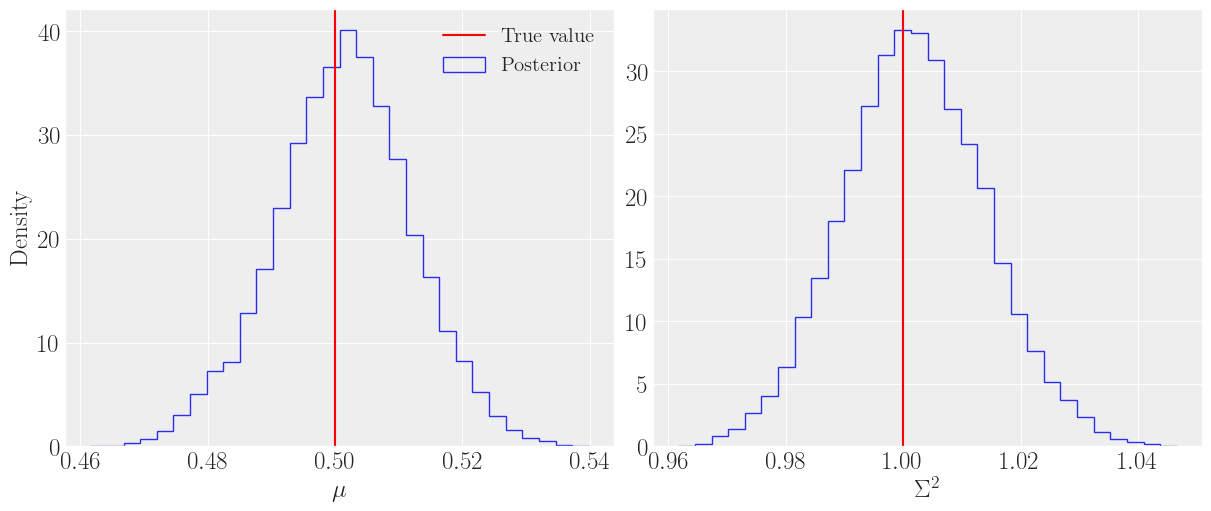

In [55]:
figure = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.subplot(121)
plt.hist(mu_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=mu_true, c="r", label="True value")
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.legend(loc="best")

plt.subplot(122)
plt.hist(Sigma2_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=Sigma_true**2, c="r", label="True value")
plt.xlabel("$\Sigma^2$")

/home/mukesh/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


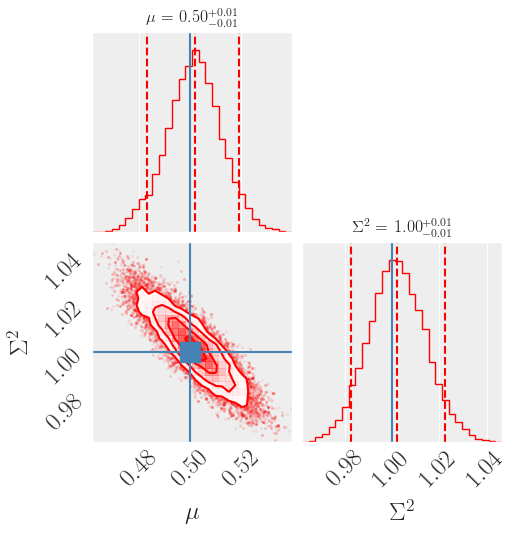

In [56]:
figure = corner.corner(org_samp, bins=30, color='r', labels=[r"$\mu$", r"$\Sigma^2$"],
                      show_titles=True, title_kwargs={"fontsize": 12}, truths=[mu_true, Sigma_true**2],
                      quantiles=[0.05, 0.5, 0.95])

### Numerical

In [69]:
# number of samples
N_samples = 2*10**2

# generating samples
theta = np.random.normal(mu_true, Sigma_true, N_samples)

# generating noise
noise = np.random.normal(0.0, sigma, N_samples)

# Observations
data = theta + noise

In [70]:
d_th = 0.0

selected_indices = data > d_th

data_selection_effects = data[selected_indices]

Text(0.5, 0, '$d$')

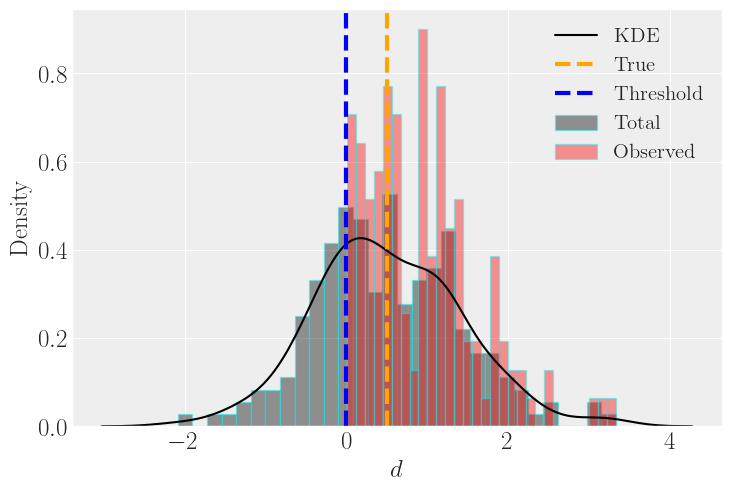

In [71]:
#plt.figure(figsize=(10, 7))
plt.hist(data, density=True,label='Total',bins=30,histtype = 'bar',
                               color ='black', alpha=0.4, edgecolor='cyan')
plt.hist(data_selection_effects, density=True,label='Observed',bins=30,histtype = 'bar',
                               color ='r', alpha=0.4, edgecolor='cyan')
sns.kdeplot(np.array(data), label='KDE',c='black')
plt.axvline(x=mu_true, label='True', c='orange',ls='--',lw=3)
plt.axvline(x=d_th, label='Threshold', c='b',ls='--',lw=3)
plt.ylabel('Density')
plt.legend(loc='best')
plt.xlabel('$d$')
#plt.grid()

In [72]:
def model_prob(theta, mu, Sigma):
    ''' 
    Inputs:
    -------------------------------------------------
    data  : data points observed 
    mu    : mean of the hyper-model 
    Sigma : standard deviation of hyper-model 
    
    Output:
    -------------------------------------------------
    prob  : hyper-model probability
    '''
    
    num = np.exp(- (theta - mu)**2 / (2 * Sigma**2))
    den = np.sqrt(2 * np.pi * Sigma**2)
    prob = num / den
    
    return prob

In [73]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.
mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = 1e-6
Sigma_sq_max_prior = 5.0

#assume that width of the noise distribution is known
sigma = sigma

def log_likelihood(params, data, d_th):
    ''' 
    Inputs:
    -------------------------------------------------
    data  : data points observed 
    params    : hyper-parameters of the hyper-model 
    
    Output:
    -------------------------------------------------
    log_likelihood  : log of hyper-likelihood
    '''
    
    # Specify a set of flat priors.
    if (params[0] >= mean_min_prior)& (params[0] <= mean_max_prior)& (params[1] >= Sigma_sq_min_prior)& \
    (params[1] <= Sigma_sq_max_prior) == 1:
        #draw samples
        log_likelihood = 0.0
        
        alpha_lambda = selection_effects(d_th, params[0], params[1], sigma**2)
        
        for d in data:
            
            # generating posteriors over signal parameter theta for each data points d_i
            theta_samples = np.random.normal(d, sigma, 10000)
            N_draw = len(theta_samples)
            
            model_probability = model(data, params[0], np.sqrt(params[1]), sigma)
            
            log_likelihood = np.sum(np.log(model_probability/alpha_lambda))
            
        return log_likelihood
    
    else:
        return -np.inf

In [78]:
n_iter = 5000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [mu_true, Sigma_true**2]

# Perturb the initial position by a bit.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data_selection_effects, d_th])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [23:54<00:00,  3.49it/s]


In [79]:
"""
Collect the samples here.
"""
burnin = 500 # discard first 1500 points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() 
org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (18000, 2)
median =  [-0.18685603  1.56500661]


Text(0.5, 0, '$\\Sigma^2$')

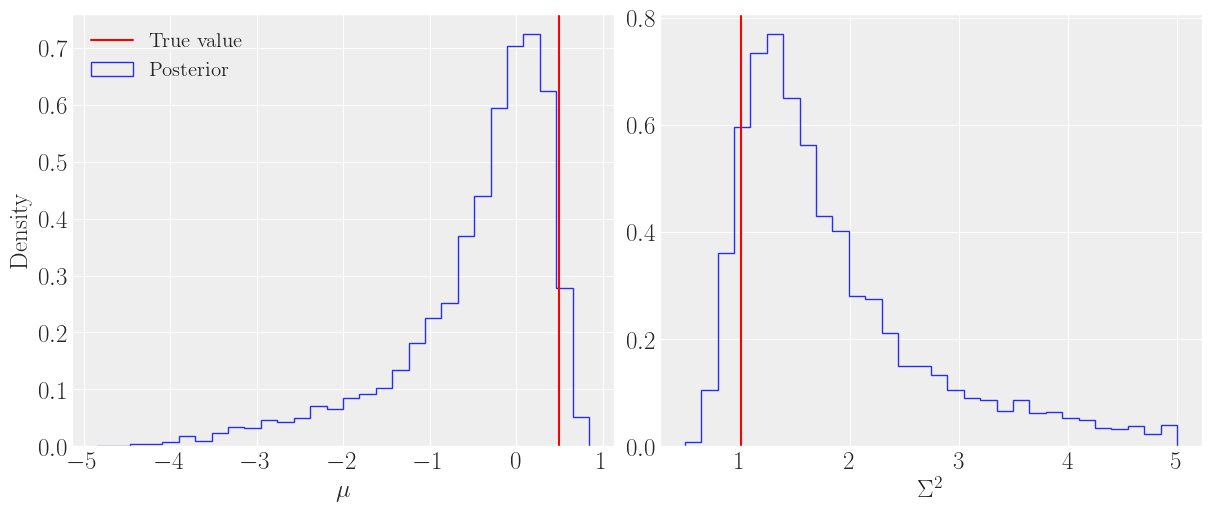

In [80]:
figure = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.subplot(121)
plt.hist(mu_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=mu_true, c="r", label="True value")
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.legend(loc="best")

plt.subplot(122)
plt.hist(Sigma2_samples, bins=30, density=True, histtype=u'step', label="Posterior")
plt.axvline(x=Sigma_true**2, c="r", label="True value")
plt.xlabel("$\Sigma^2$")

/home/mukesh/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


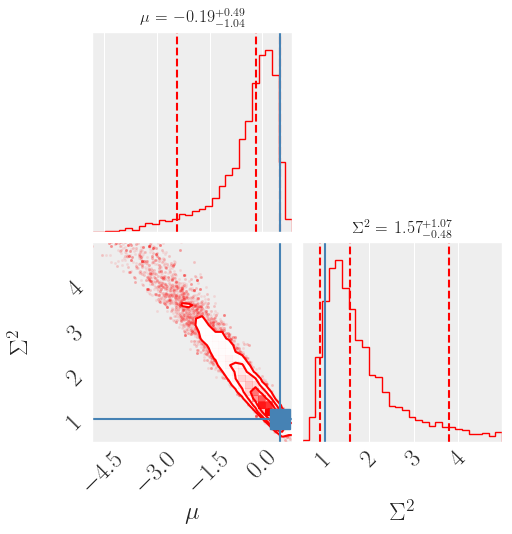

In [81]:
figure = corner.corner(org_samp, bins=30, color='r', labels=[r"$\mu$", r"$\Sigma^2$"],
                      show_titles=True, title_kwargs={"fontsize": 12}, truths=[mu_true, Sigma_true**2],
                      quantiles=[0.05, 0.5, 0.95])